In [117]:
import matplotlib.pyplot as plt
import numpy as np
# fr_om scipy.special import jn_zer_os, j0
import scipy.special

In [118]:
r_o = 1e6
z_o = 0
rho_min = 0
rho_max = 2
rho_b = 1
r_min = r_o - rho_max
r_max = r_o + rho_max
z_min = z_o - rho_max
z_max = z_o + rho_max
n_r = 1024
n_z = 1024
a_star = scipy.special.jn_zeros(0, 1)[0] # = 2.4048255576957727
psi_o = 1
a = psi_o * a_star**2 / rho_b


In [119]:
r_vec = np.linspace(r_min, r_max, n_r)
z_vec = np.linspace(z_min, z_max, n_z)
r_grid, z_grid = np.meshgrid(r_vec, z_vec)

In [ ]:
def analytic_solution(r, z):
    """
    Computes the analytic solution ψ(r, z) to the Grad-Shafranov equation 
    in cylindrical coordinates, assuming radial symmetry.

    The solution is defined piecewise in terms of the radial coordinate ρ:

        ρ = sqrt((r - r₀)^2 + (z - z₀)^2)

    For ρ ≤ ρ_b:
        ψ(ρ) = ψ₀ * J₀(a* * ρ / ρ_b)

    For ρ > ρ_b:
        ψ(ρ) = -ψ₀ * a* * J₁(a*) * ln(ρ / ρ_b)

    where:
        - ψ₀ is a constant (normalization factor)
        - a* is a dimensionless parameter
        - ρ_b is the boundary radius
        - J₀ and J₁ are Bessel functions of the first kind (orders 0 and 1)

    Parameters:
        r (float): Radial coordinate
        z (float): Axial coordinate

    Returns:
        float: Value of the analytic solution ψ at the point (r, z)
    """

    rho = np.sqrt((r-r_o)**2 + (z-z_o)**2)

    soln = psi_o * scipy.special.j0(a_star * rho / rho_b)                   * (rho <= rho_b) + \
           -psi_o * a_star * scipy.special.j1(a_star) * np.log(rho / rho_b) * (rho > rho_b)

    return soln    


Text(0.5, 1.0, 'Analytic solution to Grad-Shafranov equation')

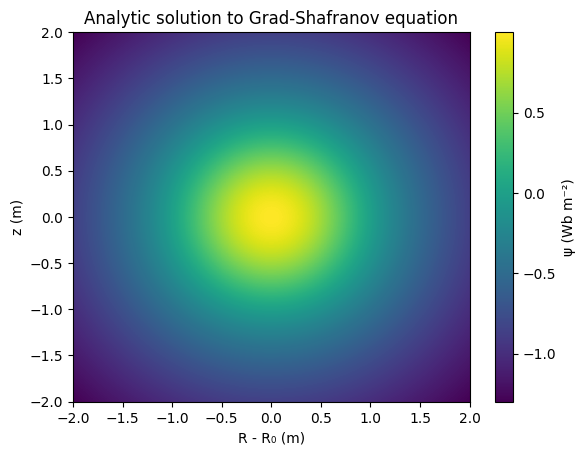

In [121]:
psi = analytic_solution(r_grid, z_grid)

# Make pcolormesh of psi values
fig, ax = plt.subplots()
pcolormesh = ax.pcolormesh(r_vec - r_o, z_vec, psi)
fig.colorbar(pcolormesh, ax=ax, label='ψ (Wb m⁻²)')
ax.set_xlabel('R - R₀ (m)')
ax.set_ylabel('z (m)')
ax.set_title('Analytic solution to Grad-Shafranov equation')



Text(0.5, 1.0, 'Grad-Shafranov RHS')

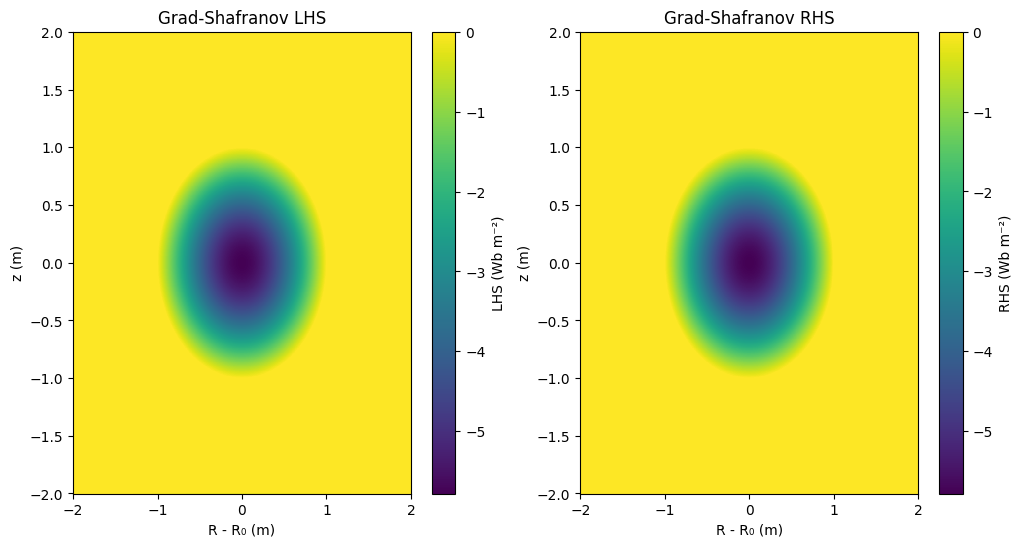

In [122]:
# Check GS LHS equals RHS
def gs_lhs(psi, r):
    """
    Computes the left-hand side of the Grad-Shafranov equation.

    Parameters:
        psi (float): Psi function

    Returns:
        ndarray: Left-hand side of the Grad-Shafranov equation
    """
    dpsi_dr = np.gradient(psi, r_vec, axis=0)
    d2psi_dr2 = np.gradient(dpsi_dr, r_vec, axis=0)
    dpsi_dz = np.gradient(psi, z_vec, axis=1)
    d2psi_dz2 = np.gradient(dpsi_dz, z_vec, axis=1)

    return d2psi_dr2 - dpsi_dr / r + d2psi_dz2

def gs_rhs(psi, r):
    """
    Computes the right-hand side of the Grad-Shafranov equation.

    Parameters:
        psi (float): Psi function

    Returns:
        ndarray: Right-hand side of the Grad-Shafranov equation
    """

    psi_n = (psi_o - psi) / psi_o
    return -a * (1 - psi_n) * (psi > 0)

gs_lhs_values = gs_lhs(psi, r_grid)
gs_rhs_values = gs_rhs(psi, r_grid)

# Make pcolormesh of GS LHS and RHS values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
pcolormesh_lhs = ax1.pcolormesh(r_vec - r_o, z_vec, gs_lhs_values)
pcolormesh_rhs = ax2.pcolormesh(r_vec - r_o, z_vec, gs_rhs_values)
fig.colorbar(pcolormesh_lhs, ax=ax1, label='LHS (Wb m⁻²)')
fig.colorbar(pcolormesh_rhs, ax=ax2, label='RHS (Wb m⁻²)')
ax1.set_xlabel('R - R₀ (m)')
ax1.set_ylabel('z (m)')
ax1.set_title('Grad-Shafranov LHS')
ax2.set_xlabel('R - R₀ (m)')
ax2.set_ylabel('z (m)')
ax2.set_title('Grad-Shafranov RHS')


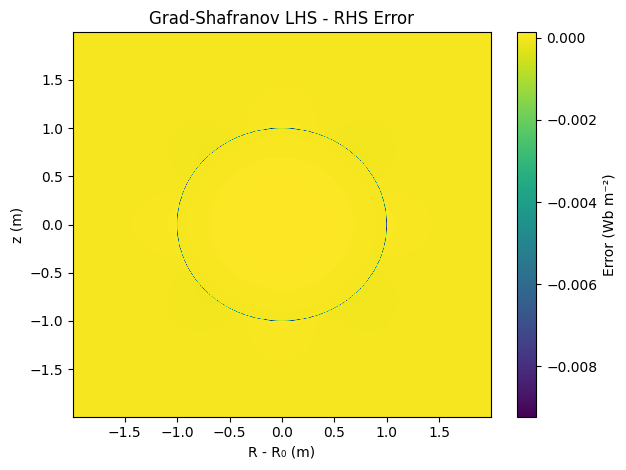

In [123]:
error = gs_lhs_values - gs_rhs_values
# Make pcolormesh of error values
fig, ax = plt.subplots()
pcolormesh_error = ax.pcolormesh(r_vec[2:-2] - r_o, z_vec[2:-2], error[2:-2, 2:-2])
fig.colorbar(pcolormesh_error, ax=ax, label='Error (Wb m⁻²)')
ax.set_xlabel('R - R₀ (m)')
ax.set_ylabel('z (m)')
ax.set_title('Grad-Shafranov LHS - RHS Error')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Grad-Shafranov LHS - RHS Error at z = z₀')

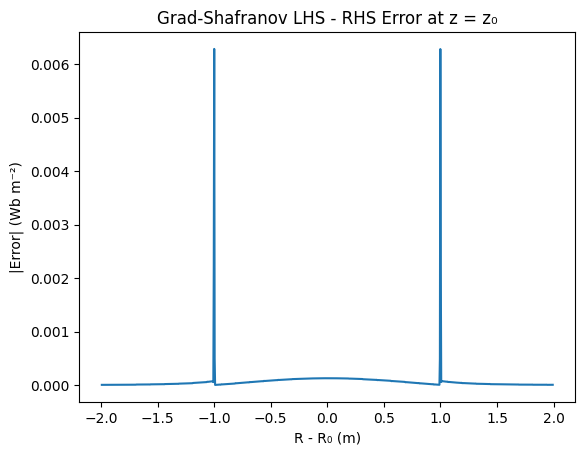

In [124]:
# Make line plot of error at z = z_o
z_o_index = n_z // 2
error_at_z_o = error[:, z_o_index]
fig, ax = plt.subplots()
ax.plot(r_vec[2:-2] - r_o, np.abs(error_at_z_o[2:-2]))
ax.set_xlabel('R - R₀ (m)')
ax.set_ylabel('|Error| (Wb m⁻²)')
ax.set_title('Grad-Shafranov LHS - RHS Error at z = z₀')